In [6]:
import xlrd
book = xlrd.open_workbook("data/Table S2 - Positional variability and color of all neurons in males and hermaphrodites v2.xlsx")

print("Worksheet names: {0}".format(book.sheet_names()))

data = {'Hermaphrodite Head':{}, 'Hermaphrodite Tail':{},'Male Head':{}, 'Male Tail':{}}

for ws in range(book.nsheets):
    sheet_name = book.sheet_names()[ws]
    
    print('Parsing sheet: %s'%sheet_name)
    sh = book.sheet_by_index(ws)
    
    for rx in range(sh.nrows):
            
        if rx>1 and rx<192:
            neuron = sh.row(rx)[0].value
            ref = '%s %s'%(sheet_name.split()[0],sheet_name.split()[1])
            if 'Positions' in sheet_name:
                data[ref][neuron]={}
                data[ref][neuron]['volume'] = sh.row(rx)[1].value
                data[ref][neuron]['ap_position'] = sh.row(rx)[2].value
                data[ref][neuron]['dv_position'] = sh.row(rx)[3].value
                data[ref][neuron]['lr_position'] = sh.row(rx)[4].value
                #'A-P Distance (μm)	D-V Distance (μm)	L-R Distance (μm)	A-P Variance (μm2)	D-V Variance (μm2)	L-R Variance (μm2)	Effect Size (D
            if 'Colors' in sheet_name:
                if neuron in data[ref]:
                    data[ref][neuron]['mNeptune2.5'] = sh.row(rx)[1].value
                    data[ref][neuron]['CyOFP1'] = sh.row(rx)[2].value
                    data[ref][neuron]['mTagBFP2'] = sh.row(rx)[3].value
                
import pprint
pp = pprint.PrettyPrinter(indent=4)

#pp.pprint(data)
            

Worksheet names: ['Hermaphrodite Head Positions', 'Hermaphrodite Head Colors', 'Hermaphrodite Tail Positions', 'Hermaphrodite Tail Colors', 'Male Head Positions', 'Male Head Colors', 'Male Tail Positions', 'Male Tail Colors']
Parsing sheet: Hermaphrodite Head Positions
Parsing sheet: Hermaphrodite Head Colors
Parsing sheet: Hermaphrodite Tail Positions
Parsing sheet: Hermaphrodite Tail Colors
Parsing sheet: Male Head Positions
Parsing sheet: Male Head Colors
Parsing sheet: Male Tail Positions
Parsing sheet: Male Tail Colors


In [7]:

for ref in data:
     
    for neuron in data[ref]:
        #print('Handling neuron %s'%neuron)
        if neuron in data[ref]:
            try:
                color = translate_pal_color(data[ref][neuron]['mNeptune2.5'],
                                            data[ref][neuron]['CyOFP1'],
                                            data[ref][neuron]['mTagBFP2'])
            except:
                color= (0,0,0)

            data[ref][neuron]['color'] = color
            label = '%s %s'%(neuron, [float('%.2f'%f) for f in color])
            data[ref][neuron]['label'] = label
            print(label)
        

ADAR [0.49, 0.37, 0.17]
ADEL [0.99, 0.18, 0.15]
ADER [1.0, 0.25, 0.16]
ADFL [0.08, 0.01, 0.09]
ADFR [0.07, 0.01, 0.09]
ADLL [0.08, 0.0, 0.21]
ADLR [0.09, 0.0, 0.21]
AFDL [0.0, 0.03, 0.0]
AFDR [0.0, 0.03, 0.0]
AIAL [0.26, 1.0, 0.13]
AIAR [0.22, 0.73, 0.14]
AIBL [0.83, 0.23, 0.16]
AIBR [0.79, 0.07, 0.14]
AIML [0.77, 0.39, 0.12]
AIMR [0.74, 0.19, 0.11]
AINL [0.1, 0.0, 0.39]
AINR [0.1, 0.01, 0.44]
AIYL [0.13, 0.47, 0.54]
AIYR [0.09, 0.02, 0.41]
AIZL [0.48, 0.23, 0.09]
AIZR [0.46, 0.23, 0.07]
ALA [0.0, 0.08, 0.0]
AMSOL [0.08, 0.01, 0.34]
AMSOR [0.08, 0.01, 0.37]
AQR [0.68, 0.76, 1.0]
AS1 [0.07, 0.02, 0.77]
ASEL [0.04, 0.03, 0.14]
ASER [0.0, 0.01, 0.06]
ASGL [0.08, 0.01, 0.48]
ASGR [0.07, 0.02, 0.49]
ASHL [0.22, 0.04, 0.3]
ASHR [0.2, 0.05, 0.28]
ASIL [0.08, 0.01, 0.16]
ASIR [0.07, 0.0, 0.14]
ASJL [0.08, 0.01, 0.18]
ASJR [0.09, 0.01, 0.18]
ASKL [0.13, 0.01, 0.21]
ASKR [0.13, 0.01, 0.21]
AUAL [0.56, 0.13, 0.14]
AUAR [0.54, 0.37, 0.14]
AVAL [0.82, 0.04, 0.61]
AVAR [0.82, 0.04, 0.55]
AVBL [0.11,

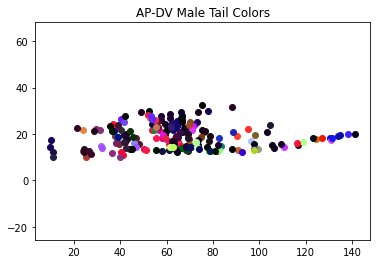

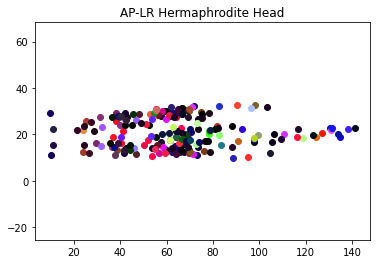

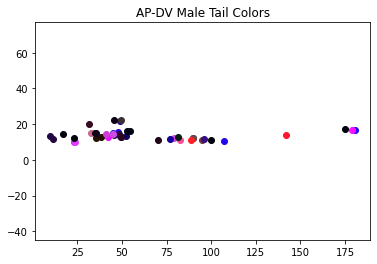

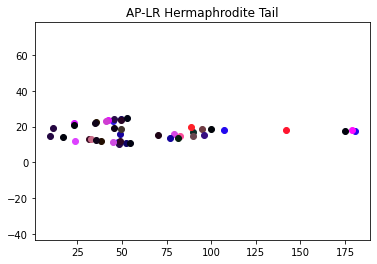

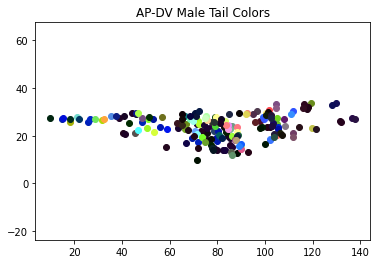

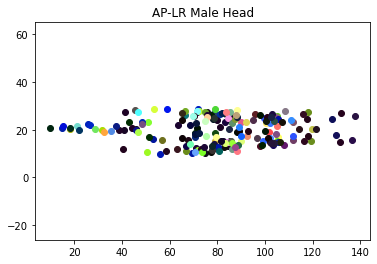

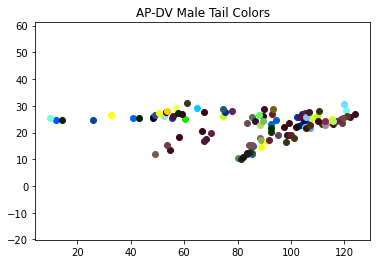

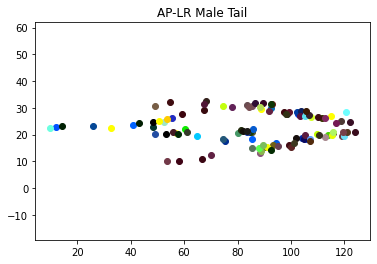

In [8]:
import matplotlib.pyplot as plt

def translate_pal_color(mneptune,cyofp1, mtag):
    # Very, very, very approximately!
    return (mneptune,min(1, cyofp1/0.05), mtag)


for ref in data:
    plt.figure()
    plt.title('AP-DV %s'%sheet_name)
    plt.axis('equal')
    for neuron in data[ref]:
        
        plt.plot(data[ref][neuron]['ap_position'], 
                 data[ref][neuron]['dv_position'], 
                 marker="o",
                color=data[ref][neuron]['color'],
                label=data[ref][neuron]['label'])

    #plt.legend()

    plt.figure()
    plt.title('AP-LR %s'%ref)
    plt.axis('equal')
    for neuron in data[ref]:

        plt.plot([data[ref][neuron]['ap_position']], 
                 [data[ref][neuron]['lr_position']], 
                 marker="o",
                color=data[ref][neuron]['color'],
                label=data[ref][neuron]['label'])
    #plt.legend()

plt.show()